In [1]:
import keras
from keras.models import Sequential, Model, load_model

from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, BatchNormalization, LocallyConnected2D, Permute
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers
from keras import backend as K
import keras.losses

import tensorflow as tf
from tensorflow.python.framework import ops

import isolearn.keras as iso

import numpy as np

import tensorflow as tf
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import pandas as pd

import os
import pickle
import numpy as np

import random

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

import isolearn.io as isoio
import isolearn.keras as isol

from genesis.visualization import *
from genesis.generator import *
from genesis.predictor import *
from genesis.optimizer import *

from definitions.generator.aparent_deconv_conv_generator_concat import load_generator_network
from definitions.predictor.aparent import load_saved_predictor

import sklearn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from scipy.stats import pearsonr

import seaborn as sns

from matplotlib import colors


Using TensorFlow backend.


In [2]:
#Maximize isoform proportions for all native minigene libraries

sequence_templates = [
    'CTTCCGATCTCTCGCTCTTTCTATGGCATTCATTACTCGCATCCANNNNNNNNNNNNNNNNNNNNNNNNNANNAAANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNCAGCCAATTAAGCCTGTCGTCGTGGGTGTCGAAAATGAAATAAAACAAGTCAATTGCGTAGTTTATTCAGACGTACCCCGTGGACCTAC'
]

library_contexts = [
    'doubledope'
]

target_isos = [
    1.0
]



/home/jlinder2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/jlinder2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/jlinder2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


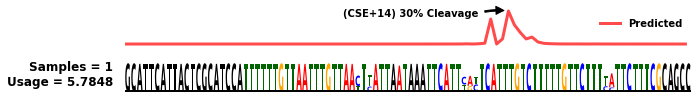

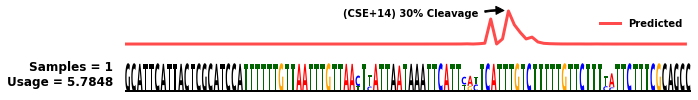

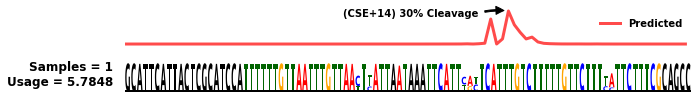

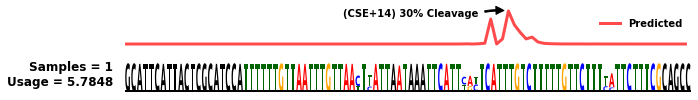

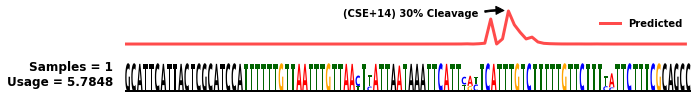

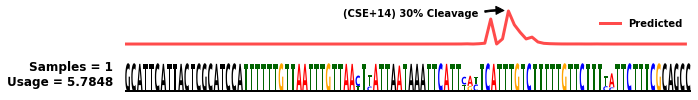

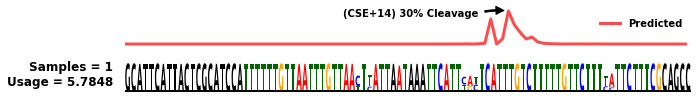

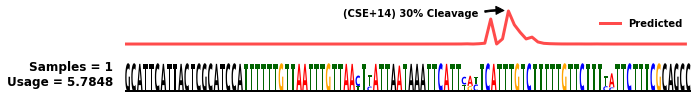

In [3]:
#Low Diversity

#(Re-)Load GENESIS model

save_dir = os.path.join(os.getcwd(), 'saved_models/target_isoform')
model_name = 'genesis_target_isoform_10_pwm_and_multisample_marginsimilarity_hardersimilarity_doubledope_sym_kl_concat_lesserpunishupc_lesspunishaa_marginsim_05_retry_1_sim_weight_025_generator.h5'
model_path = os.path.join(save_dir, model_name)

generator = load_model(model_path, custom_objects={'st_sampled_softmax': st_sampled_softmax, 'st_hardmax_softmax': st_hardmax_softmax})

save_dir = os.path.join(os.getcwd(), 'saved_models/target_isoform')
model_name = 'genesis_target_isoform_10_pwm_and_multisample_marginsimilarity_hardersimilarity_doubledope_sym_kl_concat_lesserpunishupc_lesspunishaa_marginsim_05_retry_1_sim_weight_025_predictor.h5'
model_path = os.path.join(save_dir, model_name)

predictor = load_model(model_path, custom_objects={'st_sampled_softmax': st_sampled_softmax, 'st_hardmax_softmax': st_hardmax_softmax})


#Load pre-trained predictor model
save_dir = os.path.join(os.getcwd(), '../../../aparent/saved_models')
model_name = 'aparent_plasmid_iso_cut_distalpas_all_libs_no_sampleweights_sgd.h5'
model_path = os.path.join(save_dir, model_name)

predictor_model = load_model(model_path)

n = 36

sequence_class = np.array(([0] * 36)).reshape(-1, 1)

noise_1 = np.random.uniform(-1, 1, (n, 100))
noise_2 = np.random.uniform(-1, 1, (n, 100))

pred_outputs = predictor.predict([sequence_class, noise_1, noise_2], batch_size=n)

_, _, _, optimized_pwm, _, _, _, _, _, iso_pred, cut_pred, _, _ = pred_outputs

#Plot one PWM sequence logo per optimized objective (Experiment 'Punish A-runs')

for pwm_index in range(8) :
    
    sequence_template = sequence_templates[sequence_class[pwm_index, 0]]
    
    pwm = np.expand_dims(optimized_pwm[pwm_index, :, :, 0], axis=0)
    cut = np.expand_dims(cut_pred[pwm_index, 0, :], axis=0)
    iso = np.expand_dims(iso_pred[pwm_index, 0, :], axis=0)

    plot_seqprop_logo(pwm, iso, cut, annotate_peaks='max', sequence_template=sequence_template, figsize=(10, 1.5), width_ratios=[1, 8], logo_height=0.8, usage_unit='log', plot_start=70-45, plot_end=76+45, save_figs=False, fig_name='target_isoform_genesis_class_' + str(sequence_class[pwm_index, 0]) + "_pwm_index_" + str(pwm_index), fig_dpi=150)



/home/jlinder2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/jlinder2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/jlinder2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


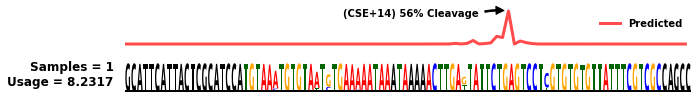

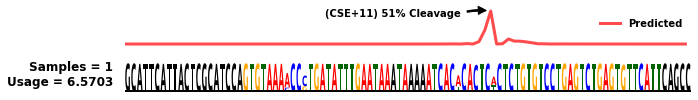

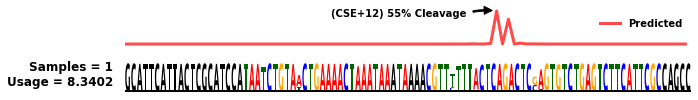

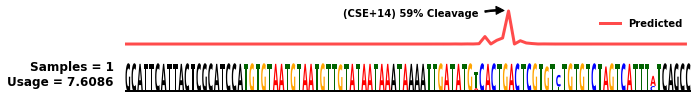

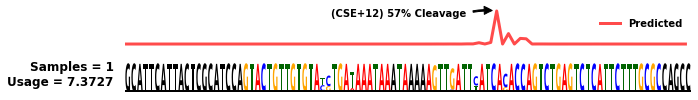

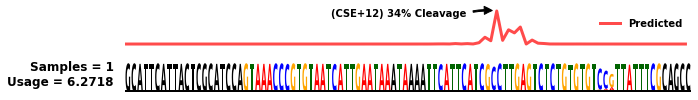

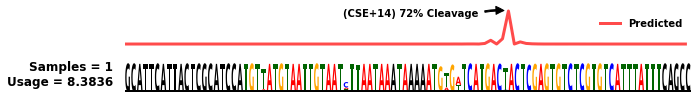

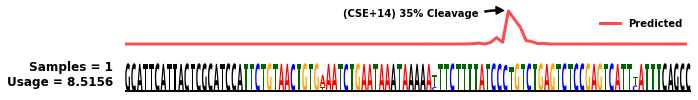

In [4]:
#High Diversity

#(Re-)Load GENESIS model

save_dir = os.path.join(os.getcwd(), 'saved_models/target_isoform')
model_name = 'genesis_target_isoform_10_pwm_and_multisample_marginsimilarity_hardersimilarity_doubledope_sym_kl_concat_lesserpunishupc_lesspunishaa_marginsim_05_retry_1_generator.h5'
model_path = os.path.join(save_dir, model_name)

generator = load_model(model_path, custom_objects={'st_sampled_softmax': st_sampled_softmax, 'st_hardmax_softmax': st_hardmax_softmax})

save_dir = os.path.join(os.getcwd(), 'saved_models/target_isoform')
model_name = 'genesis_target_isoform_10_pwm_and_multisample_marginsimilarity_hardersimilarity_doubledope_sym_kl_concat_lesserpunishupc_lesspunishaa_marginsim_05_retry_1_predictor.h5'
model_path = os.path.join(save_dir, model_name)

predictor = load_model(model_path, custom_objects={'st_sampled_softmax': st_sampled_softmax, 'st_hardmax_softmax': st_hardmax_softmax})


#Load pre-trained predictor model
save_dir = os.path.join(os.getcwd(), '../../../aparent/saved_models')
model_name = 'aparent_plasmid_iso_cut_distalpas_all_libs_no_sampleweights_sgd.h5'
model_path = os.path.join(save_dir, model_name)

predictor_model = load_model(model_path)

n = 36

sequence_class = np.array(([0] * 36)).reshape(-1, 1)

noise_1 = np.random.uniform(-1, 1, (n, 100))
noise_2 = np.random.uniform(-1, 1, (n, 100))

pred_outputs = predictor.predict([sequence_class, noise_1, noise_2], batch_size=n)

_, _, _, optimized_pwm, _, _, _, _, _, iso_pred, cut_pred, _, _ = pred_outputs

#Plot one PWM sequence logo per optimized objective (Experiment 'Punish A-runs')

for pwm_index in range(8) :
    
    sequence_template = sequence_templates[sequence_class[pwm_index, 0]]
    
    pwm = np.expand_dims(optimized_pwm[pwm_index, :, :, 0], axis=0)
    cut = np.expand_dims(cut_pred[pwm_index, 0, :], axis=0)
    iso = np.expand_dims(iso_pred[pwm_index, 0, :], axis=0)

    plot_seqprop_logo(pwm, iso, cut, annotate_peaks='max', sequence_template=sequence_template, figsize=(10, 1.5), width_ratios=[1, 8], logo_height=0.8, usage_unit='log', plot_start=70-45, plot_end=76+45, save_figs=False, fig_name='target_isoform_genesis_class_' + str(sequence_class[pwm_index, 0]) + "_pwm_index_" + str(pwm_index), fig_dpi=150)



/home/jlinder2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/jlinder2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/jlinder2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


(3600, 96)


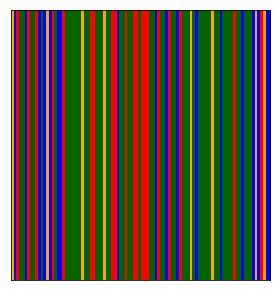

Mean Iso Prop = 0.9969
Std Iso Prop = 0.0
Mean Iso Log Odds = 5.7848
Std Iso Log Odds = 0.0
-------------------------


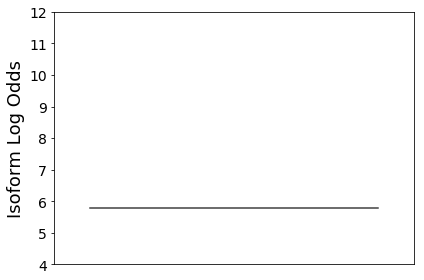

/home/jlinder2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/jlinder2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/jlinder2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


(3600, 96)


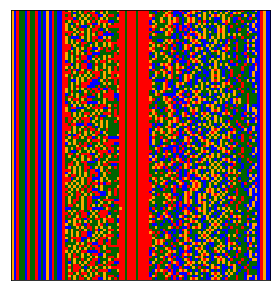

Mean Iso Prop = 0.9995
Std Iso Prop = 0.0004
Mean Iso Log Odds = 7.8973
Std Iso Log Odds = 0.6675
-------------------------


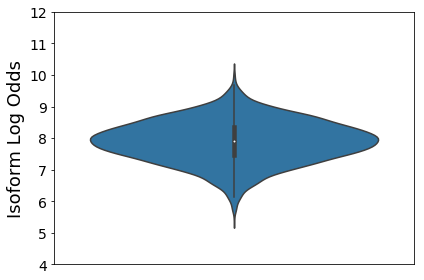

In [5]:
similarity_weights = [
    '025',
    '50'
]

model_names = [
    'genesis_target_isoform_10_pwm_and_multisample_marginsimilarity_hardersimilarity_doubledope_sym_kl_concat_lesserpunishupc_lesspunishaa_marginsim_05_retry_1_sim_weight_025',
    'genesis_target_isoform_10_pwm_and_multisample_marginsimilarity_hardersimilarity_doubledope_sym_kl_concat_lesserpunishupc_lesspunishaa_marginsim_05_retry_1'
]

save_dirs = [
    'saved_models/target_isoform',
    'saved_models/target_isoform'
]

save_figs = False

for i, similarity_weight in enumerate(similarity_weights) :

    save_dir = os.path.join(os.getcwd(), save_dirs[i])
    model_name = model_names[i] + '_generator.h5'
    model_path = os.path.join(save_dir, model_name)

    generator = load_model(model_path, custom_objects={'st_sampled_softmax': st_sampled_softmax, 'st_hardmax_softmax': st_hardmax_softmax})

    save_dir = os.path.join(os.getcwd(), save_dirs[i])
    model_name = model_names[i] + '_predictor.h5'
    model_path = os.path.join(save_dir, model_name)

    predictor = load_model(model_path, custom_objects={'st_sampled_softmax': st_sampled_softmax, 'st_hardmax_softmax': st_hardmax_softmax})


    #Load pre-trained predictor model
    save_dir = os.path.join(os.getcwd(), '../../../aparent/saved_models')
    model_name = 'aparent_plasmid_iso_cut_distalpas_all_libs_no_sampleweights_sgd.h5'
    model_path = os.path.join(save_dir, model_name)

    predictor_model = load_model(model_path)

    n = 36 * 100

    sequence_class = np.array(([0] * n)).reshape(-1, 1)

    noise_1 = np.random.uniform(-1, 1, (n, 100))
    noise_2 = np.random.uniform(-1, 1, (n, 100))

    pred_outputs = predictor.predict([sequence_class, noise_1, noise_2], batch_size=36)

    _, _, _, optimized_pwm, _, _, _, _, _, iso_pred, cut_pred, _, _ = pred_outputs


    pwms = optimized_pwm[:, :, :, 0]

    flat_pwms = np.zeros((n, 205))
    for i in range(n) :
        for j in range(205) :
            max_nt_ix = np.argmax(pwms[i, j, :])

            flat_pwms[i, j] = max_nt_ix + 1


    flat_pwms = flat_pwms[:, 70-45: 76+45]

    print(flat_pwms.shape)



    cmap = colors.ListedColormap(['red', 'blue', 'orange', 'darkgreen'])
    #cmap = colors.ListedColormap([cmap_colors(0.0), cmap_colors(0.1), cmap_colors(0.2), cmap_colors(0.3)])
    bounds=[0, 1, 2, 3, 4, 5]
    norm = colors.BoundaryNorm(bounds, cmap.N)


    f = plt.figure(figsize=(4, 12))

    plt.imshow(flat_pwms[:100, :], aspect='equal', interpolation='nearest', origin='lower', cmap=cmap, norm=norm)

    plt.xticks([], [])
    plt.yticks([], [])

    plt.tight_layout()

    if save_figs :
        plt.savefig('genesis_apa_max_isoform_doubledope_repel_' + str(similarity_weight) + '_seqs.png', transparent=True, dpi=150)
        plt.savefig('genesis_apa_max_isoform_doubledope_repel_' + str(similarity_weight) + '_seqs.svg')
        plt.savefig('genesis_apa_max_isoform_doubledope_repel_' + str(similarity_weight) + '_seqs.eps')

    plt.show()



    logodds_pred = np.log(iso_pred[:, 0, 0] / (1.0 - iso_pred[:, 0, 0]))

    print("Mean Iso Prop = " + str(round(np.mean(iso_pred[:, 0, 0]), 4)))
    print("Std Iso Prop = " + str(round(np.std(iso_pred[:, 0, 0]), 4)))
    print("Mean Iso Log Odds = " + str(round(np.mean(logodds_pred), 4)))
    print("Std Iso Log Odds = " + str(round(np.std(logodds_pred), 4)))
    print("-------------------------")
    
    f = plt.figure(figsize=(6, 4))

    sns.violinplot(data=logodds_pred, axis=0)

    plt.ylim(4, 12)

    plt.xticks([], [])
    plt.yticks(fontsize=14)

    plt.ylabel('Isoform Log Odds', fontsize=18)

    plt.tight_layout()

    if save_figs :
        plt.savefig('genesis_apa_max_isoform_doubledope_repel_' + str(similarity_weight) + '_violin.png', transparent=True, dpi=150)
        plt.savefig('genesis_apa_max_isoform_doubledope_repel_' + str(similarity_weight) + '_violin.svg')
        plt.savefig('genesis_apa_max_isoform_doubledope_repel_' + str(similarity_weight) + '_violin.eps')

    plt.show()




Running version = '02'


/home/jlinder2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


N Sequences = 10
36/36 [==============================] - 1s 28ms/step
Number of unique sequences = 1
Duplication rate = 0.9
N Sequences = 100
108/108 [==============================] - 1s 10ms/step
Number of unique sequences = 1
Duplication rate = 0.99
N Sequences = 1000
1008/1008 [==============================] - 10s 10ms/step
Number of unique sequences = 1
Duplication rate = 0.999
N Sequences = 10000
10008/10008 [==============================] - 117s 12ms/step
Number of unique sequences = 1
Duplication rate = 0.9999
N Sequences = 100000
100008/100008 [==============================] - 1108s 11ms/step
Number of unique sequences = 1
Duplication rate = 1.0
Running version = '50'


/home/jlinder2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


N Sequences = 10
36/36 [==============================] - 1s 30ms/step
Number of unique sequences = 10
Duplication rate = 0.0
N Sequences = 100
108/108 [==============================] - 1s 12ms/step
Number of unique sequences = 100
Duplication rate = 0.0
N Sequences = 1000
1008/1008 [==============================] - 10s 10ms/step
Number of unique sequences = 1000
Duplication rate = 0.0
N Sequences = 10000
10008/10008 [==============================] - 112s 11ms/step
Number of unique sequences = 10000
Duplication rate = 0.0
N Sequences = 100000
100008/100008 [==============================] - 1100s 11ms/step
Number of unique sequences = 100000
Duplication rate = 0.0


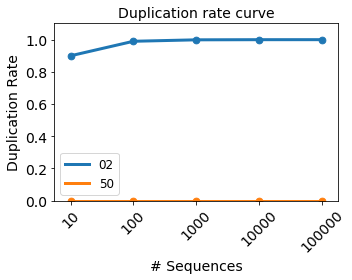

In [5]:

#Estimate duplication rates

def get_consensus_sequence(pwm) :
    consensus = ''
    
    for j in range(pwm.shape[0]) :
        nt_ix = np.argmax(pwm[j, :])
        
        if nt_ix == 0 :
            consensus += 'A'
        elif nt_ix == 1 :
            consensus += 'C'
        elif nt_ix == 2 :
            consensus += 'G'
        elif nt_ix == 3 :
            consensus += 'T'
    
    return consensus

f = plt.figure(figsize=(5, 4))

n_sequences_large_list = [10, 100, 1000, 10000, 100000]

ls = []

save_figs = False


similarity_weights = [
    '025',
    '50'
]

model_names = [
    'genesis_target_isoform_10_pwm_and_multisample_marginsimilarity_hardersimilarity_doubledope_sym_kl_concat_lesserpunishupc_lesspunishaa_marginsim_05_retry_1_sim_weight_025',
    'genesis_target_isoform_10_pwm_and_multisample_marginsimilarity_hardersimilarity_doubledope_sym_kl_concat_lesserpunishupc_lesspunishaa_marginsim_05_retry_1'
]

save_dirs = [
    'saved_models/target_isoform',
    'saved_models/target_isoform'
]

max_dup_rate = 0.

for i, similarity_weight in enumerate(similarity_weights) :

    print("Running version = '" + similarity_weights[i] + "'")
    
    save_dir = os.path.join(os.getcwd(), save_dirs[i])
    model_name = model_names[i] + '_predictor.h5'
    model_path = os.path.join(save_dir, model_name)

    predictor = load_model(model_path, custom_objects={'st_sampled_softmax': st_sampled_softmax, 'st_hardmax_softmax': st_hardmax_softmax})    
    
    dup_rates = []
    
    k = i
    
    for n_sequences_large in n_sequences_large_list :
        n_sequences_ceil_large = int(n_sequences_large / 36) * 36 + 36

        print("N Sequences = " + str(n_sequences_large))

        sequence_class = np.tile(np.array([[0]]), (n_sequences_ceil_large, 1))

        noise_1 = np.random.uniform(-1, 1, (n_sequences_ceil_large, 100))
        noise_2 = np.random.uniform(-1, 1, (n_sequences_ceil_large, 100))

        pred_outputs = predictor.predict([sequence_class, noise_1, noise_2], batch_size=36, verbose=True)

        _, _, _, optimized_pwm_large, _, sampled_pwm_large, _, _, _, _, _, _, _ = pred_outputs

        onehots_large = sampled_pwm_large[:, 0, :, :, :]


        consensus_seqs_large = []

        for ii in range(onehots_large.shape[0]) :
            consensus_seqs_large.append(get_consensus_sequence(onehots_large[ii, :, :, 0]))

        consensus_seqs_large = np.array(consensus_seqs_large, dtype=np.object)

        #Sample first n_sequences
        onehots_large_kept = onehots_large[:n_sequences_large, :, :]
        consensus_large_seqs_kept = consensus_seqs_large[:n_sequences_large]

        n_unique_seqs_kept = len(np.unique(consensus_large_seqs_kept))

        print("Number of unique sequences = " + str(n_unique_seqs_kept))

        dup_rate = 1. - n_unique_seqs_kept / n_sequences_large
        dup_rates.append(dup_rate)

        print("Duplication rate = " + str(round(dup_rate, 4)))


    l1 = plt.plot(np.arange(len(n_sequences_large_list)), dup_rates, linewidth=3, linestyle='-', label="" + str(similarity_weights[i]))
    plt.scatter(np.arange(len(n_sequences_large_list)), dup_rates, s=45)
    
    ls.append(l1[0])
    
    max_dup_rate = max(max_dup_rate, np.max(dup_rates))

plt.xlabel("# Sequences", fontsize=14)
plt.ylabel("Duplication Rate", fontsize=14)
plt.xticks(np.arange(len(n_sequences_large_list)), n_sequences_large_list, fontsize=14, rotation=45)
plt.yticks(fontsize=14)

plt.ylim(0, max_dup_rate * 1.10 + 0.001)

plt.title("Duplication rate curve", fontsize=14)

plt.legend(handles=ls, fontsize=12)

plt.tight_layout()

if save_figs :
    plt.savefig("apa_isoform_doubledope_eval_sim_weight_dup_rate_curve.eps")
    plt.savefig("apa_isoform_doubledope_eval_sim_weight_dup_rate_curve.svg")
    plt.savefig("apa_isoform_doubledope_eval_sim_weight_dup_rate_curve.png", transparent=True, dpi=150)

plt.show()


In [6]:
import scipy
import scipy.sparse as sp

#Helper function to get the conensus sequence from a PWM
def get_consensus_sequence(pwm) :
    consensus = ''
    
    for j in range(pwm.shape[0]) :
        nt_ix = np.argmax(pwm[j, :])
        
        if nt_ix == 0 :
            consensus += 'A'
        elif nt_ix == 1 :
            consensus += 'C'
        elif nt_ix == 2 :
            consensus += 'G'
        elif nt_ix == 3 :
            consensus += 'T'
    
    return consensus



similarity_weights = [
    '025',
    '50'
]

model_names = [
    'genesis_target_isoform_10_pwm_and_multisample_marginsimilarity_hardersimilarity_doubledope_sym_kl_concat_lesserpunishupc_lesspunishaa_marginsim_05_retry_1_sim_weight_025',
    'genesis_target_isoform_10_pwm_and_multisample_marginsimilarity_hardersimilarity_doubledope_sym_kl_concat_lesserpunishupc_lesspunishaa_marginsim_05_retry_1'
]

save_dirs = [
    'saved_models/target_isoform',
    'saved_models/target_isoform'
]

n_sequences = 1000
n_sequences_ceil = int(n_sequences / 36) * 36 + 36

onehot_encoder = isol.OneHotEncoder(205)

consensus_seqs = []
onehot_seqs = []

for k, similarity_weight in enumerate(similarity_weights) :

    print("Running version = '" + similarity_weights[k] + "'")
    
    save_dir = os.path.join(os.getcwd(), save_dirs[k])
    model_name = model_names[k] + '_predictor.h5'
    model_path = os.path.join(save_dir, model_name)

    predictor = load_model(model_path, custom_objects={'st_sampled_softmax': st_sampled_softmax, 'st_hardmax_softmax': st_hardmax_softmax})    
    
    sequence_class = np.tile(np.array([[0]]), (n_sequences_ceil, 1))
    
    noise_1 = np.random.uniform(-1, 1, (n_sequences_ceil, 100))
    noise_2 = np.random.uniform(-1, 1, (n_sequences_ceil, 100))
    
    pred_outputs = predictor.predict([sequence_class, noise_1, noise_2], batch_size=36)
    _, _, _, optimized_pwm, _, _, _, _, _, _, _, _, _ = pred_outputs

    optimized_pwm = np.expand_dims(optimized_pwm[:n_sequences, :, :, 0], axis=0)
    
    consensus_seqs.append([])
    onehot_seqs.append([])
    for i in range(n_sequences) :
        consensus_seqs[k].append(get_consensus_sequence(optimized_pwm[0, i, :, :]))
        onehot_seqs[k].append(onehot_encoder(get_consensus_sequence(optimized_pwm[0, i, :, :])))
    
    consensus_seqs[k] = np.expand_dims(np.array(consensus_seqs[k], dtype=np.object), axis=0)
    onehot_seqs[k] = np.expand_dims(onehot_seqs[k], axis=0)
    
    
    consensus_seqs_ent = consensus_seqs[k][0]
    consensus_seqs_ent = np.array(consensus_seqs_ent, dtype=np.object)

    #Sample first n_sequences
    onehots_kept = onehot_seqs[k][0, :n_sequences, :, :]
    consensus_seqs_kept = consensus_seqs_ent[:n_sequences]

    print("Number of unique sequences = " + str(len(np.unique(consensus_seqs_kept))))

    #Calculate average/std nucleotide entropy

    nt_entropies = []
    for j in range(onehots_kept.shape[1]) :
        if sequence_templates[0][j] == 'N' :

            p_A = np.sum(onehots_kept[:, j, 0]) / n_sequences
            p_C = np.sum(onehots_kept[:, j, 1]) / n_sequences
            p_G = np.sum(onehots_kept[:, j, 2]) / n_sequences
            p_T = np.sum(onehots_kept[:, j, 3]) / n_sequences

            nt_entropy = 0
            if p_A * p_C * p_G * p_T > 0. :
                nt_entropy = - (p_A * np.log2(p_A) + p_C * np.log2(p_C) + p_G * np.log2(p_G) + p_T * np.log2(p_T))

            nt_entropies.append(nt_entropy)

    nt_entropies = np.array(nt_entropies)

    print("Mean NT Entropy = " + str(round(np.mean(nt_entropies), 4)))
    print("Std NT Entropy = " + str(round(np.std(nt_entropies), 4)))


    #Calculate hexamer entropies

    hexamer_encoder = isol.NMerEncoder(n_mer_len=6, count_n_mers=True)

    hexamers = isol.SparseBatchEncoder(encoder=hexamer_encoder)([x[20:128] for x in consensus_seqs_kept])

    print(hexamers.shape)

    hexamer_sum = np.ravel(hexamers.sum(axis=0))

    hexamers_probs = hexamer_sum / np.sum(hexamer_sum)

    n_nonzero_hexamers = len(np.nonzero(hexamer_sum > 0)[0])

    print("Number of unique hexamers = " + str(n_nonzero_hexamers))


    hexamer_entropy = -1. * np.sum(hexamers_probs[hexamer_sum > 0] * np.log2(hexamers_probs[hexamer_sum > 0]))

    print("Hexamer Entropy = " + str(hexamer_entropy))


    #Calculate average/std hexamer entropy

    nonzero_index = np.nonzero(hexamer_sum > 0)[0]

    hexamer_entropies = []
    for j in range(n_nonzero_hexamers) :
        p_on = len(np.nonzero(hexamers[:, nonzero_index[j]] > 0)[0]) / hexamers.shape[0]
        p_off = 1. - p_on

        hexamer_entropy = 0
        if p_on * p_off > 0. :
            hexamer_entropy = -(p_on * np.log2(p_on) + p_off * np.log2(p_off))

        hexamer_entropies.append(hexamer_entropy)

    hexamer_entropies = np.array(hexamer_entropies)

    print("Mean Binary Hexamer Entropy = " + str(round(np.mean(hexamer_entropies), 4)))
    print("Std Binary Hexamer Entropy = " + str(round(np.std(hexamer_entropies), 4)))



Running version = '02'


/home/jlinder2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Number of unique sequences = 1
Mean NT Entropy = 0.0
Std NT Entropy = 0.0
(1000, 4096)
Number of unique hexamers = 85
Hexamer Entropy = 6.283493002869365
Mean Binary Hexamer Entropy = 0.0
Std Binary Hexamer Entropy = 0.0
Running version = '50'


/home/jlinder2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Number of unique sequences = 1000
Mean NT Entropy = 1.5043
Std NT Entropy = 0.6107
(1000, 4096)
Number of unique hexamers = 1892
Hexamer Entropy = 8.837253867961957
Mean Binary Hexamer Entropy = 0.1643
Std Binary Hexamer Entropy = 0.205
